# BDM Project Team 10 Portfolio selection, Optimization and Comparison



# <u>Introduction</u>

Hello! Welcome to our notebook on Stock portfolio selection, optimization and comparison.
<br>
<br>
In this notebook we aim to guide you on our project, while showing you our code and results in a well documented manner. Below is the gist of our work:
<br>
<br>
* In this project, we select 30 stocks from 2017-2021, 10 from each sector of Financials, Materials and Consumer Discretionary ; as assigned to us by our mentor.
<br>
<br>
* Following this, we perform momentum trading (strategy where we stay invested only if the 8 day moving average of the stock is higher than the 21 day moving average of the stock) on these stocks to identify three best performing stocks for each sector mentioned above. (Total of 9)
<br>
<br>
* Upon choosing the 9 stocks, we optimize these stocks using pyomo and ipopt by maximizing the stock returns for various levels of risk.
<br>
<br>
* From this we choose an appropriate risk level containing proportions from 3 stocks as our MPT portfolio.
<br>
<br>
* To benchmark the performance of the portfolio, we used the well-known S&P 500 stock for the year 2022 to which we perform buy-and-hold strategy (Buy the stocks and check stock value over time) as well as momentum trading strategy. Correspondingly, we compare Buy-and-hold and momentum trading strategies for our MPT portfolio (for the same year) as well and compare the performance.
<br>
<br>
* Finally, we provided the conclusions and inferences from this analysis to gain some insights and experience on stock portfolio optimization.
<br>
<br>
We hope the rest of the notebook provides detailed account of what we've accomplished.
<br>
<br>
P.S. Please use the Table of contents on the left tab to quickly navigate to any section of our notebook


# <u>Members</u>
1. Kanchan Sharma
2. Lakshmi Venkata Pavani Pratyusha Bodasakurthi
3. Srihari Madhavan
4. Vaishnavi Tiwari

# <u>Import libraries</u>
First we import all the important libraries useful for our project

In [2]:
# some useful modules
import numpy as np
import pandas as pd # for data manipulation
import datetime as dt
!pip install matplotlib

import matplotlib.pyplot as plt
import seaborn as sns # for visualization
from pylab import *
!pip install iteround
from iteround import saferound # To round values while keeping the sum value of 1
!pip install shutup
import shutup
shutup.please() # To shut up all warnings

from sklearn.preprocessing import MinMaxScaler # For scaling the data

Financial libraries for getting stock data

In [3]:
# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.8 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=de1023e3b834b658461219ccf04c97f87c351fe5fde6f3cab740f9a5575a4ce8
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=04eec37b718277598435287a4a4ed353b7047781cc61915930aae3ff8693cbe0
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found exis

Import and set up the optimization tools

In [4]:
# Installing vital optimization packages
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.3 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 97.2MB/s]


# <u>Stock download cleaning and Visualization</u>

First we start with selecting stocks from the sectors provided

* Financials sector
* Materials sector
* Customer Discretionary sector

We selected 10 stocks from each sector to select the top 9 among these

In [5]:
# Assign the ticker list that we want to scrap
tickers_list = ['AXP','BAC','COF','C','DFS','GS','HIG','JPM','MA','PYPL',
                'EMN','FMC','FCX','IFF','IP','LIN','NEM','NUE','SHW','VMC',
                'AZO','BBWI','GRMN','GM','LEN','RCL','SBUX','TSCO','VFC','WYNN']
sector = ['Financials','Financials','Financials','Financials','Financials',
          'Financials','Financials','Financials','Financials','Financials',
          'Materials','Materials','Materials','Materials','Materials',
          'Materials','Materials','Materials','Materials','Materials',
          'Consumer Discretionary','Consumer Discretionary',
          'Consumer Discretionary','Consumer Discretionary','Consumer Discretionary',
          'Consumer Discretionary','Consumer Discretionary',
          'Consumer Discretionary','Consumer Discretionary','Consumer Discretionary']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}

In [6]:
# take a peak at the downoladed stocks
dow_prices

{'AXP':                   open        high         low       close    adjclose  \
 2017-01-03   74.889999   75.750000   74.739998   75.349998   68.054146   
 2017-01-04   75.260002   76.550003   75.059998   76.260002   69.169807   
 2017-01-05   76.000000   76.180000   74.820000   75.320000   68.317169   
 2017-01-06   75.400002   75.919998   75.059998   75.470001   68.453247   
 2017-01-09   76.139999   76.500000   75.529999   75.860001   68.806992   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  163.860001  166.399994  163.589996  164.190002  159.725388   
 2021-12-27  165.000000  165.000000  162.529999  164.389999  159.919952   
 2021-12-28  163.600006  166.130005  163.600006  164.410004  159.939423   
 2021-12-29  164.619995  164.929993  163.259995  163.830002  159.375183   
 2021-12-30  164.619995  165.800003  164.000000  164.160004  159.696198   
 
              volume ticker  
 2017-01-03  5853900    AXP  
 2017-01-04  4635800    AXP  
 

### Data Preparation
Now let's put all these stocks in a dataframe

In [7]:
# combine all the tickers (all the rest of the samples)
prep_data = pd.DataFrame()
for i in tickers_list:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data.head()

,AXP,BAC,COF,C,DFS,GS,HIG,JPM,MA,PYPL,...,AZO,BBWI,GRMN,GM,LEN,RCL,SBUX,TSCO,VFC,WYNN
2017-01-03,68.054146,19.283401,78.186272,48.693359,62.033115,208.953018,40.669224,71.641151,101.200584,40.250000,...,791.460022,42.422539,40.607307,30.282772,39.690620,77.689903,48.071968,68.184746,40.362125,80.401535
2017-01-04,69.169807,19.642883,79.444397,49.352345,63.065132,210.302399,41.350594,71.773300,102.160851,41.000000,...,793.039978,42.906780,41.135647,31.954136,40.670868,78.273468,48.627834,68.984299,40.603996,82.993935
2017-01-05,68.317169,19.411793,77.755180,48.492435,62.178123,208.736786,41.180237,71.112610,102.949883,41.060001,...,792.000000,39.529789,40.854958,31.351065,41.077766,78.736633,49.036011,67.942207,40.241203,84.060310
2017-01-06,68.453247,19.411793,77.948753,48.661205,61.461647,211.833405,41.265415,71.120872,103.690811,41.450001,...,792.909973,39.013702,40.483482,31.006460,40.402699,78.116013,49.617924,67.519981,40.195843,84.970421
2017-01-09,68.806992,19.300520,76.928200,48.396004,61.086384,210.094788,40.941761,71.170418,103.488731,41.400002,...,790.340027,39.058296,39.699234,31.023682,40.273239,78.319794,50.547226,67.708641,40.006874,85.264595


### Data Cleaning
Cleaning and removing any NAs from the dataframe

In [8]:
prep_data.shape # shape of the prepared data

(1258, 30)

In [9]:
prep_data.isna().sum() # Count of missing/NA records


AXP     0
BAC     0
COF     0
C       0
DFS     0
GS      0
HIG     0
JPM     0
MA      0
PYPL    0
EMN     0
FMC     0
FCX     0
IFF     0
IP      0
LIN     0
NEM     0
NUE     0
SHW     0
VMC     0
AZO     0
BBWI    0
GRMN    0
GM      0
LEN     0
RCL     0
SBUX    0
TSCO    0
VFC     0
WYNN    0
dtype: int64

In [10]:
# Just to make sure there are no NAs
prep_data.dropna(inplace=True)
prep_data.shape

(1258, 30)

### Stock data Visualization

Taking a look at the 30 stocks to check the data and gain some insights

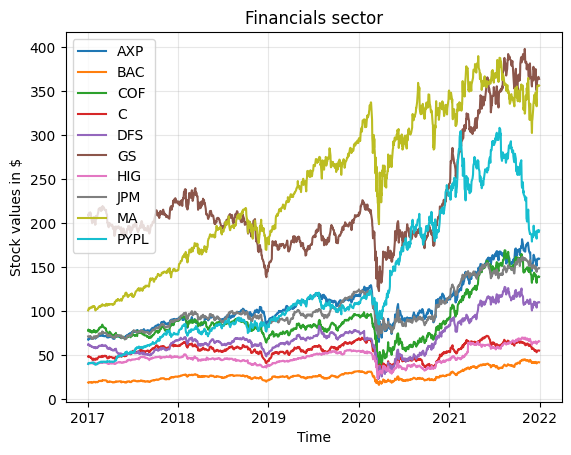

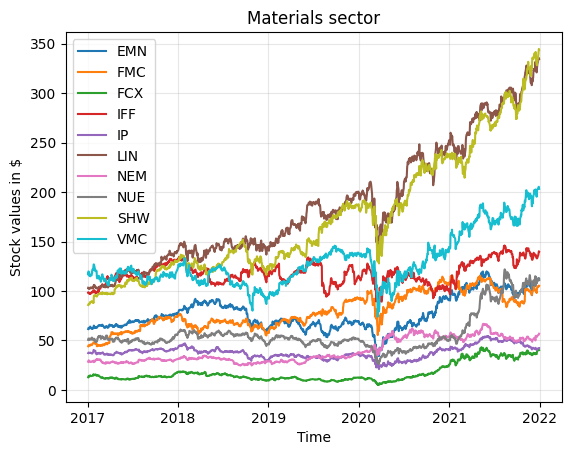

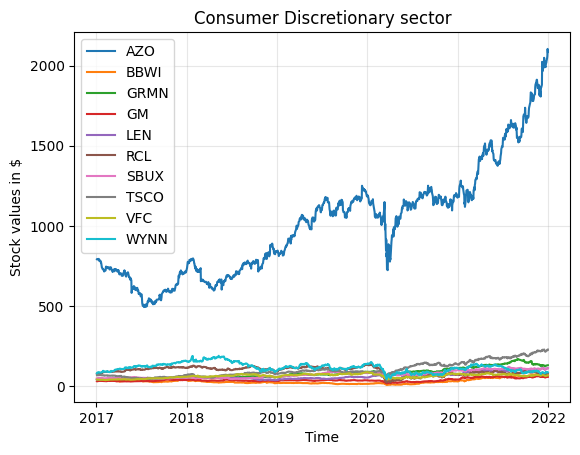

In [11]:
# Plot the stocks based on sector
for i in range(3):
  plt.figure(i)
  plt.title(sector[10*i]+' sector') # Adding stock sector titles
  for j in range(10):
    plt.plot(prep_data[tickers_list[10*i+j]], label=tickers_list[10*i+j]) # Plotting the stocks together

  plt.legend(loc=2)
  plt.grid(True, alpha=.3)
  plt.ylabel('Stock values in $')
  plt.xlabel('Time')
  plt.show()

<u>Insights</u>
<br>
General comments: While this gives a decent view of the stocks. It does not give insights on which stocks are the best. This is due to the issue that each stock has a different initial stock value and in this visualization, stocks with high stock value overpower other stocks. But we are more interested in the rate of growth of the stocks, not their stock value. Hence in the next plot we show the stocks scaled down by their inital stock value to get a better view of their performance


In [12]:
norm_data = pd.DataFrame() # New dataframe to visualise scaled stocks

norm_data = (prep_data/prep_data.iloc[0])-1 # Scale the stock values by the inital stock value
norm_data.head()

,AXP,BAC,COF,C,DFS,GS,HIG,JPM,MA,PYPL,...,AZO,BBWI,GRMN,GM,LEN,RCL,SBUX,TSCO,VFC,WYNN
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,0.016394,0.018642,0.016091,0.013533,0.016637,0.006458,0.016754,0.001845,0.009489,0.018634,...,0.001996,0.011415,0.013011,0.055192,0.024697,0.007511,0.011563,0.011726,0.005993,0.032243
2017-01-05,0.003865,0.006658,-0.005514,-0.004126,0.002338,-0.001035,0.012565,-0.007378,0.017285,0.020124,...,0.000682,-0.068189,0.006099,0.035277,0.034949,0.013473,0.020054,-0.003557,-0.002996,0.045506
2017-01-06,0.005864,0.006658,-0.003038,-0.000660,-0.009212,0.013785,0.014660,-0.007262,0.024607,0.029814,...,0.001832,-0.080354,-0.003049,0.023898,0.017941,0.005485,0.032159,-0.009749,-0.004120,0.056826
2017-01-09,0.011062,0.000888,-0.016091,-0.006107,-0.015262,0.005464,0.006701,-0.006571,0.022610,0.028571,...,-0.001415,-0.079303,-0.022362,0.024466,0.014679,0.008108,0.051491,-0.006983,-0.008802,0.060485


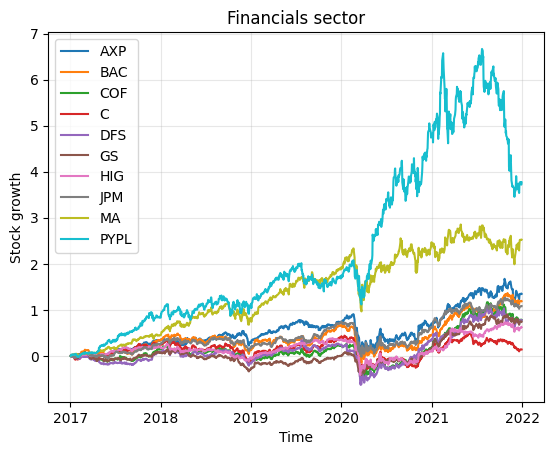

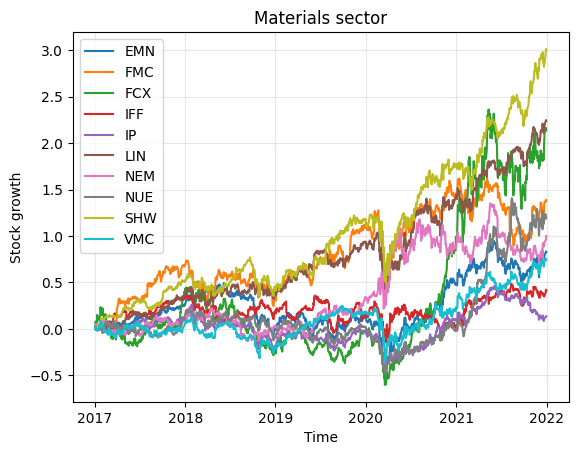

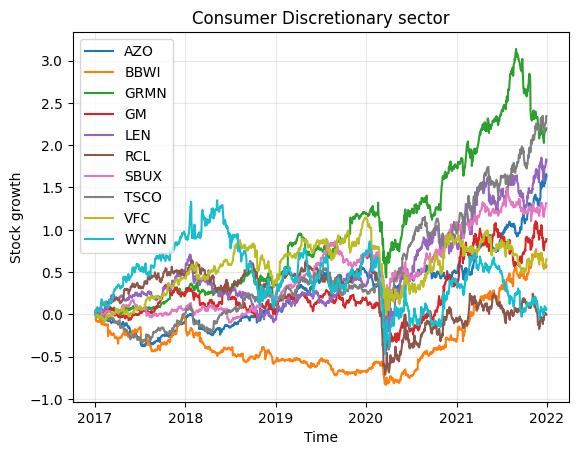

In [13]:
# Plot the stocks based on sector
for i in range(3):
  plt.figure(i)
  plt.title(sector[10*i]+' sector') # Adding stock sector titles
  for j in range(10):
    plt.plot(norm_data[tickers_list[10*i+j]], label=tickers_list[10*i+j]) # Plotting the stocks together

  plt.legend(loc=2)
  plt.grid(True, alpha=.3)
  plt.ylabel('Stock growth')
  plt.xlabel('Time')
  plt.show()

### <u>Insights</u>
<br>
From the above visualisations we can notice the growth of the stocks in a more intuitive manner.
<br><br>
Financials sector: PYPl and MA seem to have the best growth in their stock values and dominate over the other stocks. The top 3 stocks which seem to grow the highest are PYPL, MA and AXP
<br><br>
Materials sector:While SHW seems to grow the highest, the other stocks are not far behind and grow quite close together. The top 3 stocks which seem to grow the highest are SHW, LIN and FCX
<br><br>
Consumer Discretionary sector: Similar to the above sector , the stocks seem to grow in a close race with the 'winners' barely performing better than the other stocks. Although one stock (BBWI) seems to perform very poorly, lying well below 0 for a huge part of the time period. The top 3 stocks which seem to grow the highest are TSCO, GRMN and LEN

(<u>Note:</u> The top 3 growing stocks mentioned are <u>NOT</u> the stocks we choose from each sector, but instead our guess on which stocks would likely be the best when momentum trading is applied)




#<u>Momentum Trading</u>
### Create a momentum trading function

Created a momentum trading function which (as mentioned in the introduction) performs trading simulations of the stocks by comparing the moving average of 8 days and 21 days. If the 8 days moving average iis higher than the other, then we invest/stay invested. If it's not, then we stop investing/ stay uninvested.  

In [14]:
def momentum_trading(tdf,indices):
  for i in indices:
    tdf[i+'8-day'] = tdf[i].rolling(8).mean().shift() # 8 day shift in stocks
    tdf[i+'21-day'] = tdf[i].rolling(21).mean().shift() # 21 day shift in stocks

  tdf.dropna(inplace=True) # Remove shifts in the stocks

  for i in indices:
    tdf[i+'logClose'] = np.log(tdf[i]) # price will always be positive, so this operation is well-defined
    tdf[i+'return'] = tdf[i+'logClose'].diff() # the difference will be positive or negative
    tdf.loc[tdf.index[0],i+'return'] = 0.0 # Setting the return column first value to 0.0
    tdf[i+'invested'] = np.where(tdf[i+'8-day'] > tdf[i+'21-day'], 1, 0) # investment state
    tdf[i+'system_return'] = tdf[i+'invested'] * tdf[i+'return'] # Earnings using momentum trading strategy

  return tdf

### Perform Momentum trading on the stocks

In [15]:
b_returns = [] # Buy and hold strategy returns
rdf = pd.DataFrame() # Dataframe with the returns of momentum trading model
returns = [] # Momentum Trading startegy returns
for i in tickers_list: # taking each stock from the dataframe to calculate returns

  tdf = momentum_trading(pd.DataFrame(prep_data[i]),[i]) # Calling the momentum trading function

  b_returns.append(np.exp(np.sum(tdf[i+'return'])) -1) #Buy and hold strategy returns

  returns.append(np.exp(np.sum(tdf[i+'system_return'])) -1) # Total momentum trading returns


  rdf[i] = tdf[i+'system_return'] # Storing the reutns values in a datframe

### Selecting the top 3 stocks from each sector based on momentum trading returns

In [16]:

# Splitting the returns based on sectors
finance_returns = returns[0:10]
finance = tickers_list[0:10]
materials_returns = returns[10:20]
materials = tickers_list[10:20]
consumer_discretionary_returns = returns[20:30]
consumer_discretionary = tickers_list[20:30]

#Sorting financial returns to choose top 3
finance_returns, finance = zip(*sorted(zip(finance_returns,
                                           finance),reverse = True))
print('\n Top 10 '+sector[0])
print(finance_returns)
print(finance)

#Sorting materials returns to choose top 3

materials_returns, materials = zip(*sorted(zip(materials_returns,
                                           materials),reverse = True))
print('\n Top 10 '+sector[10])
print(materials_returns)
print(materials)

#Sorting Consumer discretionary returns to choose top 3
consumer_discretionary_returns, consumer_discretionary = zip(*sorted(zip(consumer_discretionary_returns,
                                           consumer_discretionary),reverse = True))
print('\n Top 10 '+sector[20])
print(consumer_discretionary_returns)
print(consumer_discretionary)

# Stock list of all top 3 stoks from each sector
new_tickers = list(finance[0:3]) + list(materials[0:3]) + list(consumer_discretionary[0:3])

#Top 9 stocks from 3 sectors
print('\n Top 9 stocks from 3 sectors \n' + str(new_tickers))
print('\n'+'Data of top 9 stocks')
new_data = prep_data[new_tickers]
print(new_data.head())


 Top 10 Financials
(1.7875546820871695, 0.9893449557631795, 0.8789243649377916, 0.6013451976651916, 0.44635656810540447, 0.07205470335030117, 0.03985696392317495, 0.022538610307847762, -0.05564437686601009, -0.19276377148606316)
('PYPL', 'DFS', 'MA', 'HIG', 'COF', 'BAC', 'AXP', 'GS', 'JPM', 'C')

 Top 10 Materials
(1.6354511122805366, 0.8584336763573495, 0.8227946766484491, 0.6107153006910646, 0.3432867722810691, 0.29843806720815347, 0.01409239582931976, -0.06582452303634223, -0.06633635561845908, -0.2133637570604966)
('SHW', 'NUE', 'FCX', 'LIN', 'EMN', 'FMC', 'VMC', 'IFF', 'NEM', 'IP')

 Top 10 Consumer Discretionary
(1.7013029652275624, 1.6201558269847496, 1.0026760266503971, 0.9218841741558057, 0.7157655839214425, 0.42711851880858354, 0.3012622393363724, 0.19205424596156018, 0.14156755613317706, -0.1394161990596211)
('TSCO', 'GRMN', 'AZO', 'GM', 'SBUX', 'LEN', 'BBWI', 'VFC', 'WYNN', 'RCL')

 Top 9 stocks from 3 sectors 
['PYPL', 'DFS', 'MA', 'SHW', 'NUE', 'FCX', 'TSCO', 'GRMN', 'AZ

### Momentum trading performance plots

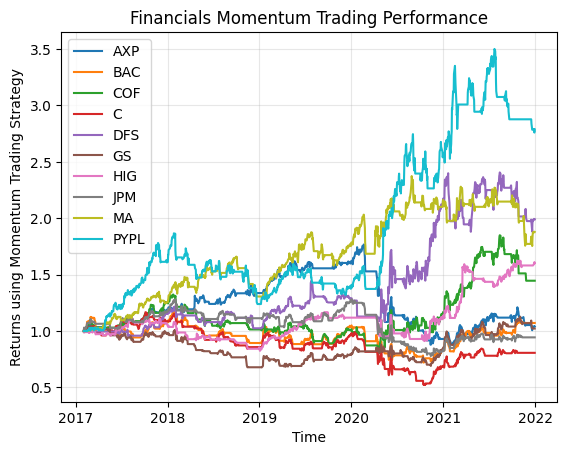

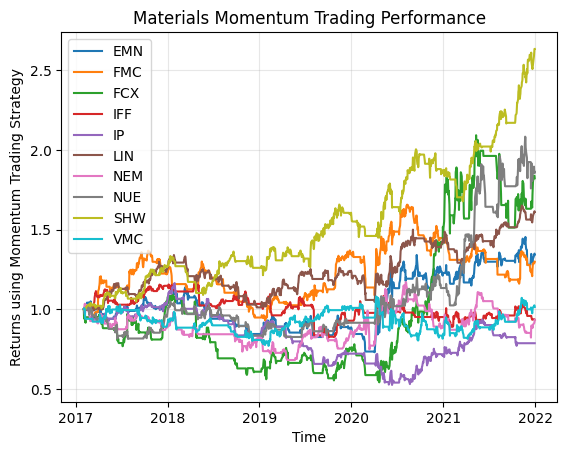

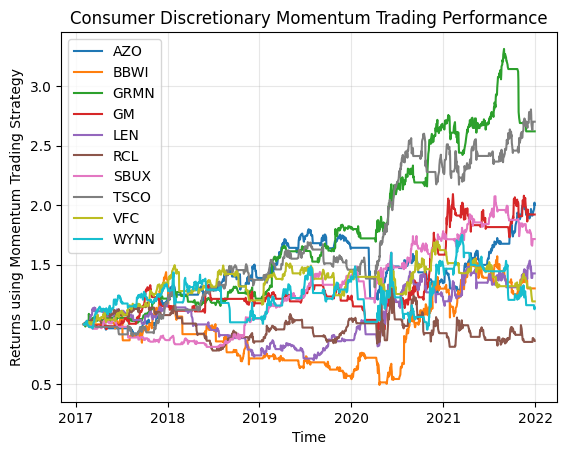

In [17]:

# Showing the momentum trading performance of stocks in each sector
for i in range(3):
  plt.figure(i)
  plt.title(sector[10*i]+' Momentum Trading Performance')
  for j in range(10):
    plt.plot(np.exp(rdf[tickers_list[10*i+j]]).cumprod(), label=tickers_list[10*i+j]) # Momentum tading performance of each stock

  plt.legend(loc=2)
  plt.grid(True, alpha=.3)
  plt.ylabel('Returns using Momentum Trading Strategy')
  plt.xlabel('Time')
  plt.show()

### Momentum Trading Conclusions
With the Momentum trading done we can see that some of the stocks we predicted to perform well actually did (around 2 in 3)
We <u>PREDICTED</u> the top 9 stocks to be 'PYPL', 'MA', 'AXP', 'SHW', 'LIN', 'FCX', 'TSCO', 'GRMN', 'LEN'
<br>
<br>
But upon Momentum trading we got the <u>ACTUAL</u> list of optimal stocks as **<u>'PYPL', 'DFS', 'MA', 'SHW', 'NUE', 'FCX', 'TSCO', 'GRMN', 'AZO'</u>**. This might be due to the high variability of some of the predicted stocks which caused them to perform worse in momentum trading
<br>
<br>
Looking into the top momentum trading stocks by sector:

Financials sector: Top performing stocks are PYPL, DFS and MA

Materials sector: Top performing stocks are SHW, NUE, FCX

Consumer Discretionary Sector: Top performing stocks are TSCO, GRMN, AZO

# Portfolio Optimization

Now we select stocks from these top 3 stocks from momentum trading in each sector and optimize these 9 stocks to to find a proportion with 3 stocks at an appropriate risk level

### Convert chosen stock data to % change

In [18]:
# create return features for each ticker,
# we will just use a pct_change as the return
pctchange_data = pd.DataFrame()
for i in new_tickers:
  pctchange_data[i] = new_data[i].pct_change()
# drop the na records
pctchange_data.dropna(inplace=True)
pctchange_data

,PYPL,DFS,MA,SHW,NUE,FCX,TSCO,GRMN,AZO
2017-01-04,0.018634,0.016637,0.009489,0.006775,0.027512,0.076197,0.011726,0.013011,0.001996
2017-01-05,0.001463,-0.014065,0.007723,-0.000796,-0.005714,-0.014160,-0.015106,-0.006824,-0.001311
2017-01-06,0.009498,-0.011523,0.007197,0.010174,-0.010016,0.019152,-0.006214,-0.009093,0.001149
2017-01-09,-0.001206,-0.006106,-0.001949,-0.000825,-0.010781,-0.014765,0.002794,-0.019372,-0.003241
2017-01-10,-0.007729,0.006841,-0.002139,0.000431,0.026492,0.059264,0.013003,-0.003327,0.004226
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.001722,0.004179,0.008672,-0.001004,0.005808,0.024664,0.004135,0.002833,-0.004772
2021-12-27,0.000000,0.006763,-0.000749,0.021189,0.020560,0.020909,0.014018,0.010857,0.016163
2021-12-28,-0.009947,-0.000431,0.001304,0.008248,-0.018860,0.000000,-0.001296,-0.001324,0.006292
2021-12-29,-0.000684,-0.002585,0.001414,0.008496,0.003845,-0.000238,0.024181,0.001915,0.021408


### Calculate covariance and mean of the data

In [19]:
# covariance matrix of the stocks
new_data_cov = pctchange_data.cov()
print('Covariance Matrix:')
print(new_data_cov)

# mean matrix of the stocks
new_data_mean = pctchange_data.mean()
print('Average Return:')
print(new_data_mean)

Covariance Matrix:
          PYPL       DFS        MA       SHW       NUE       FCX      TSCO  \
PYPL  0.000506  0.000243  0.000278  0.000177  0.000159  0.000286  0.000149   
DFS   0.000243  0.000765  0.000331  0.000224  0.000367  0.000514  0.000137   
MA    0.000278  0.000331  0.000370  0.000164  0.000201  0.000304  0.000105   
SHW   0.000177  0.000224  0.000164  0.000273  0.000167  0.000220  0.000121   
NUE   0.000159  0.000367  0.000201  0.000167  0.000498  0.000436  0.000143   
FCX   0.000286  0.000514  0.000304  0.000220  0.000436  0.001038  0.000181   
TSCO  0.000149  0.000137  0.000105  0.000121  0.000143  0.000181  0.000338   
GRMN  0.000161  0.000225  0.000172  0.000133  0.000172  0.000236  0.000109   
AZO   0.000112  0.000224  0.000126  0.000136  0.000127  0.000189  0.000136   

          GRMN       AZO  
PYPL  0.000161  0.000112  
DFS   0.000225  0.000224  
MA    0.000172  0.000126  
SHW   0.000133  0.000136  
NUE   0.000172  0.000127  
FCX   0.000236  0.000189  
TSCO  0.000

### Create model stock variables
These variables shall hold the proportion of each stock to invest in

In [20]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock

for i in range(1,10):
  setattr(m,'stock'+str(i),Var(within=NonNegativeReals, bounds=(0,1)))


### Creating the objective function
The objective function is the equation we want to maximize/minimize.
In our case, we want to maximize the returns from the all stocks

$Maximize (Objective) = \sum_{i=1}^n proportion_{stock_i}*mean(returns_{stock_i})$

In [21]:
# Objective function for selecting stocks based on mean stock value
def objective(m):
  sum = 0
  for i in range(9):
    sum+= getattr(m,"stock"+str(i+1))*new_data_mean[i]
  return sum

# declare objective
m.objective = Objective(expr =
                        objective(m)
                        , sense=maximize)  # yes, we want to MAX our returns!
# declare constraints
# 1. Sum of all proportions = 1
def sum_proportions(m):
  sum = 0
  for i in range(9):
    sum += getattr(m,"stock"+str(i+1))
  #print(sum)
  return sum

# 2. Setting sum of all stocks to 1
m.sum_proportions = Constraint(expr = sum_proportions(m) == 1)

# 3. Set maximum risk (Tmporary constraint will be changed later)
m.total_risk = Constraint(expr = sum_proportions(m) >= 0.0)

In [22]:
new_tickers

['PYPL', 'DFS', 'MA', 'SHW', 'NUE', 'FCX', 'TSCO', 'GRMN', 'AZO']

### Setting the risk constraint

Here we want to calculate the risk generated be each proportion of the stocks. To do this, we use the following formula:
$\sum_{i,j=1}^{n} proportion_{stock_i}*Cov(stock_i,stock_j)*proportion_{stock_j}$

where $n$ is the total number of stocks considered ($n$ = 9 in our case)

We are considering risk limits of around 500

In [23]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = [getattr(m,"stock"+str(i+1)) for i in range(9)]
  temp_tickers = new_tickers[:]
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*new_data_cov.at[temp_tickers[i],
                                               temp_tickers[j]]*variables[j] # Calculate risk as sum of stocki * Cov(stocki,stockj) * stockj
  return risk_exp

# 3. Maximum risk to be used
max_risk = 0.0006
# Sequence of risk levels
risk_limits = np.arange(0.00001, max_risk, 0.000001) # taking tiny steps
len(risk_limits)

590

### Running the optimization model using pyomo and ipopt

In [24]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = calc_risk(m) <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  # Write the results

  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [getattr(m,"stock"+str(i+1))() for i in range(len(new_data_mean))]
  # store our returns
  returns[r] =  np.sum([getattr(m,"stock"+str(i+1))()*new_data_mean[i] for i in range(9)])


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.009135961532592773
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# -----------------------

In [25]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')

In [26]:
len(param_analysis) # number of feasible solutions

437

### Plot the proportion vs risk levels

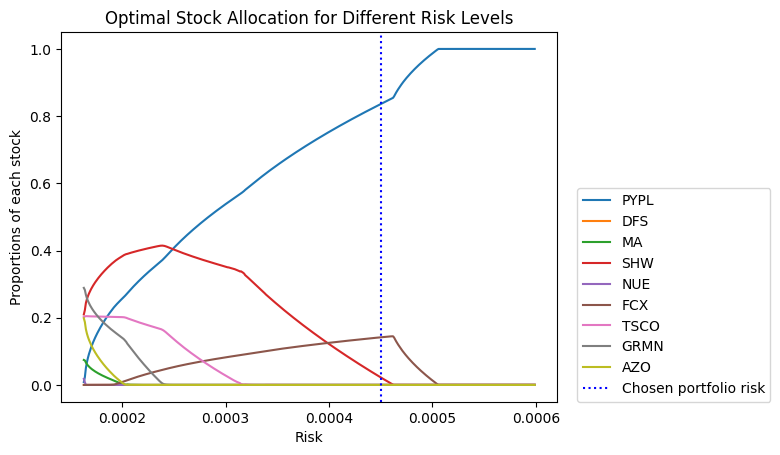

In [27]:
# Create new dataframe with risks and corresponding proportions
param_analysis.columns = new_tickers
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.axvline(x = 0.0004500000000000003, color = 'b',linestyle = 'dotted', label = 'Chosen portfolio risk') # Selected risk level and corresponding portfolio
plt.xlabel('Risk')
plt.ylabel('Proportions of each stock')
plt.legend(loc=(1.04, 0)) # Setting the legend outside the plot
plt.show()

From the above plot we selected a risk level of 0.00045 which provides us with a portfolio with 3 stocks

In [28]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward)

[0.00016300000000000009, 0.00016400000000000008, 0.00016500000000000008, 0.0001660000000000001, 0.0001670000000000001, 0.0001680000000000001, 0.0001690000000000001, 0.0001700000000000001, 0.0001710000000000001, 0.0001720000000000001, 0.00017300000000000009, 0.00017400000000000008, 0.0001750000000000001, 0.0001760000000000001, 0.0001770000000000001, 0.0001780000000000001, 0.0001790000000000001, 0.0001800000000000001, 0.0001810000000000001, 0.00018200000000000011, 0.0001830000000000001, 0.0001840000000000001, 0.0001850000000000001, 0.0001860000000000001, 0.0001870000000000001, 0.0001880000000000001, 0.0001890000000000001, 0.0001900000000000001, 0.00019100000000000012, 0.0001920000000000001, 0.0001930000000000001, 0.0001940000000000001, 0.0001950000000000001, 0.0001960000000000001, 0.0001970000000000001, 0.00019800000000000012, 0.00019900000000000012, 0.00020000000000000012, 0.00020100000000000012, 0.0002020000000000001, 0.0002030000000000001, 0.0002040000000000001, 0.0002050000000000001,

### Plot risk vs reward curve

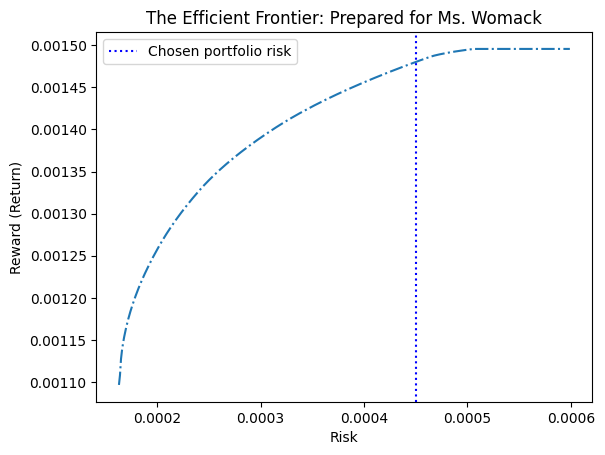

In [29]:
# plot the risk vs reward curve
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Ms. Womack')
xlabel('Risk')
ylabel('Reward (Return)')
plt.axvline(x = 0.0004500000000000003, color = 'b',linestyle = 'dotted', label = 'Chosen portfolio risk') #
plt.legend()
plt.show()

From above plot we can see that the chosen risk level gives a reward which is quite close to the maximum reward achievable

In [30]:
portfolio = pd.Series(saferound(param_analysis.loc[0.0004500000000000003],
                                    places = 3)) #  rounding to make sure they add up to 1

portfolio.index = param_analysis.columns

portfolio # optimal portfolio

PYPL    0.836
DFS     0.000
MA      0.000
SHW     0.022
NUE     0.000
FCX     0.142
TSCO    0.000
GRMN    0.000
AZO     0.000
dtype: float64

In [31]:
portfolio = portfolio.loc[portfolio > 0]
portfolio #Top 3 stocks

PYPL    0.836
SHW     0.022
FCX     0.142
dtype: float64

#Analysis

Now that we have the appropriate portfolio, we check its performance for the year 2022 while comparing with the well established SP500 stock with and without momentum trading

### Retrieving and cleaning the 2022 Portfolio stocks

In [32]:
p_tickers = portfolio.index #portfolio stocks

p_sectors = [sector[tickers_list.index(p)] for p in p_tickers] #portfolio sectors


# pull historical price data for each portfolio stock for analysis
a_prices = {ticker : si.get_data(ticker,start_date = '12/02/2021',end_date='12/31/2022',interval='1d') for ticker in p_tickers}

<u>Note:</u> The above data starts from december 2021. This is because we plan to perform momentum trading on our portfolio as well and we want to see the effect of the trading from the beginning of 2022

In [33]:
a_prices

{'PYPL':                   open        high         low       close    adjclose  \
 2021-12-02  180.104996  188.800003  179.729996  187.149994  187.149994   
 2021-12-03  187.729996  187.800003  179.289993  183.929993  183.929993   
 2021-12-06  183.410004  186.070007  179.199997  184.860001  184.860001   
 2021-12-07  188.669998  192.828003  188.429993  191.020004  191.020004   
 2021-12-08  191.949997  197.690002  190.089996  197.350006  197.350006   
 ...                ...         ...         ...         ...         ...   
 2022-12-23   68.050003   69.250000   67.709999   69.029999   69.029999   
 2022-12-27   68.959999   69.239998   67.680000   68.330002   68.330002   
 2022-12-28   68.120003   69.470001   67.292000   67.550003   67.550003   
 2022-12-29   68.389999   70.739998   68.220001   70.559998   70.559998   
 2022-12-30   69.480003   71.260002   69.059998   71.220001   71.220001   
 
               volume ticker  
 2021-12-02  20422700   PYPL  
 2021-12-03  20737500   PYPL

In [34]:
# combine all the tickers (all the rest of the samples)
portfolio_data = pd.DataFrame()
for i in p_tickers:
  portfolio_data[i] = pd.DataFrame(a_prices[i]['adjclose'])
portfolio_data.head()

,PYPL,SHW,FCX
2021-12-02,187.149994,333.144012,35.929153
2021-12-03,183.929993,335.821564,35.406197
2021-12-06,184.860001,334.575989,36.190636
2021-12-07,191.020004,335.203674,37.546448
2021-12-08,197.350006,335.645050,37.498028


Cleaning the portfolio data of the year 2022

In [35]:
portfolio_data.isna().sum() # checking for missing values

PYPL    0
SHW     0
FCX     0
dtype: int64

In [36]:
portfolio_data.dropna(inplace=True) # dropping missing values just in case
portfolio_data.head()

,PYPL,SHW,FCX
2021-12-02,187.149994,333.144012,35.929153
2021-12-03,183.929993,335.821564,35.406197
2021-12-06,184.860001,334.575989,36.190636
2021-12-07,191.020004,335.203674,37.546448
2021-12-08,197.350006,335.645050,37.498028


###Buy-and-hold and Momentum trading startegy of the portfolio

Here we are investing $100,000 in both our portfolio and S&P 500 stocks using both momentum trading and buy-and-hold strategies

In [37]:
investment = list(100000*portfolio)
investment # Investment amount of each stock

[83600.0, 2200.0, 14199.999999999998]

In [38]:

portfolio_data['MT_Total'] = 0 # Total Momentum trading returns of portfolio stocks
portfolio_data['Total_investment'] = 0 # Total buy and hold investment returns

portfolio_data = momentum_trading(portfolio_data,p_tickers)

for i in p_tickers:
  portfolio_data[i+'MTreturn'] = investment[list(p_tickers).index(i)]*np.exp(portfolio_data[i+'system_return']).cumprod() # returns for momentum trading based on amount invested

  portfolio_data[i+'invested_amt'] = np.exp(portfolio_data[i+'return']).cumprod()
  portfolio_data[i+'invested_amt'] = portfolio_data[i+'invested_amt']*investment[list(p_tickers).index(i)]  # Each stocks buy and hold return based on invested amount
  portfolio_data['Total_investment']  +=  portfolio_data[i+'invested_amt'] # Total buy and hold invested amount for the total portfolio
  portfolio_data['MT_Total'] += portfolio_data[i+'MTreturn'] # Total momentum trading invested amount for the total portfolio

portfolio_data.head()



,PYPL,SHW,FCX,MT_Total,Total_investment,PYPL8-day,PYPL21-day,SHW8-day,SHW21-day,FCX8-day,...,FCXlogClose,FCXreturn,FCXinvested,FCXsystem_return,PYPLMTreturn,PYPLinvested_amt,SHWMTreturn,SHWinvested_amt,FCXMTreturn,FCXinvested_amt
2022-01-03,194.940002,332.604614,40.170925,100000.000000,100000.000000,190.671249,189.114761,338.300522,337.004133,39.919128,...,3.693143,0.000000,1,0.000000,83600.000000,83600.000000,2200.000000,2200.000000,14200.000000,14200.000000
2022-01-04,191.139999,329.269958,40.819775,98577.673611,98577.673611,191.396250,189.485714,338.868156,336.978447,40.197556,...,3.709167,0.016023,1,0.016023,81970.369082,81970.369082,2177.943052,2177.943052,14429.361477,14429.361477
2022-01-05,187.160004,329.887848,40.364613,96714.044855,96714.044855,191.328751,189.829048,338.500366,336.666466,40.440876,...,3.697953,-0.011213,1,-0.011213,80263.548324,80263.548324,2182.030057,2182.030057,14268.466475,14268.466475
2022-01-06,192.270004,327.151428,39.250908,98493.685248,98493.685248,190.722502,189.938572,338.251492,336.443221,40.507456,...,3.669975,-0.027979,1,-0.027979,82454.971560,82454.971560,2163.930118,2163.930118,13874.783571,13874.783571
2022-01-07,187.600006,317.010101,40.558304,96886.028337,96886.028337,190.755003,189.998096,336.781540,336.059781,40.330716,...,3.702741,0.032766,1,0.032766,80452.243325,80452.243325,2096.850714,2096.850714,14336.934298,14336.934298


### Retrieving and cleaning of S&P 500 2022 stock data for analysis

In [39]:
sp500 = pd.DataFrame(si.get_data('^GSPC',start_date = '12/02/2021',end_date='12/31/2022',interval='1d')['adjclose'])
sp500.columns = ['sp500']
sp500.head() # Data for SP500 stocks in 2022


,sp500
2021-12-02,4577.100098
2021-12-03,4538.430176
2021-12-06,4591.669922
2021-12-07,4686.750000
2021-12-08,4701.209961


<u>Note:</u> The above data starts from December 2021. This is because we plan to perform momentum trading on S&P 500 as well and we want to see the effect of the trading from the beginning of 2022.

In [40]:
sp500.isna().sum()

sp500    0
dtype: int64

In [41]:

sp500.dropna(inplace=True)
sp500.head()

,sp500
2021-12-02,4577.100098
2021-12-03,4538.430176
2021-12-06,4591.669922
2021-12-07,4686.750000
2021-12-08,4701.209961


### Buy-and-hold and Momentum trading of SP500 index

In [42]:
i = 'sp500'

sp500 = momentum_trading(sp500,[i]) # Momentum traading of sp500


In [43]:
sp500.head()

,sp500,sp5008-day,sp50021-day,sp500logClose,sp500return,sp500invested,sp500system_return
2022-01-03,4796.560059,4748.386292,4682.474330,8.475654,0.000000,1,0.000000
2022-01-04,4793.540039,4766.802551,4692.924805,8.475024,-0.000630,1,-0.000630
2022-01-05,4700.580078,4778.925049,4705.072893,8.455441,-0.019583,1,-0.019583
2022-01-06,4696.049805,4775.773804,4710.259091,8.454477,-0.000964,1,-0.000964
2022-01-07,4677.029785,4763.881287,4710.701939,8.450419,-0.004058,1,-0.004058


In [44]:
sp500_investment = sp500[[i+'return',i+'system_return']] # Extracting the investment columns from sp500 dataframe
sp500_investment[i+'return'] = 100000* np.exp(sp500_investment[i+'return']).cumprod() # Calculating Buy and hold returns for full stock investment of $100,000
sp500_investment[i+'system_return'] = 100000*np.exp(sp500_investment[i+'system_return']).cumprod() # Calculating Momentum trading returns for full stock investment of $100,000

sp500_investment.head()

,sp500return,sp500system_return
2022-01-03,100000.000000,100000.000000
2022-01-04,99937.037804,99937.037804
2022-01-05,97998.983036,97998.983036
2022-01-06,97904.534652,97904.534652
2022-01-07,97508.000067,97508.000067


### Displaying the final performance plot of the stocks

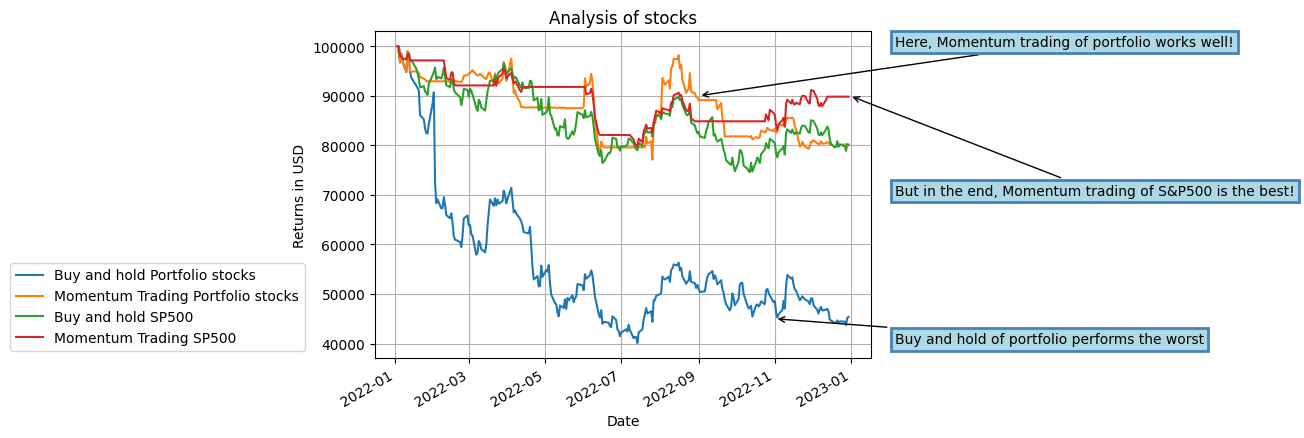

In [45]:
# Concatenating the investment returns columns to plot them together
temp = pd.concat([portfolio_data[['Total_investment','MT_Total']], sp500_investment], axis=1)
temp.columns = ['Buy and hold Portfolio stocks',
            'Momentum Trading Portfolio stocks',
            'Buy and hold SP500',
            'Momentum Trading SP500']

temp.plot()
plt.legend(loc='lower left',
           bbox_to_anchor=(-0.75, 0)) # Adding legend to the stock returns for identification

plt.grid()
plt.title('Analysis of stocks')
plt.xlabel('Date')
plt.annotate('Here, Momentum trading of portfolio works well!',
             xy=('2022-09-01', 90000),
             xytext=('2023-02-05', 100000),
             arrowprops=dict(arrowstyle="->"),
             bbox=dict(boxstyle="square",
                      fc="lightblue", ec="steelblue", lw=2))
plt.annotate('But in the end, Momentum trading of S&P500 is the best!',
             xy=('2022-12-31', 90000),
             xytext=('2023-02-05', 70000),
             arrowprops=dict(arrowstyle="->"),
             bbox=dict(boxstyle="square",
                      fc="lightblue", ec="steelblue", lw=2))
plt.annotate('Buy and hold of portfolio performs the worst',
             xy=('2022-11-01', 45000),
             xytext=('2023-02-05', 40000),
             arrowprops=dict(arrowstyle="->"),
             bbox=dict(boxstyle="square",
                      fc="lightblue", ec="steelblue", lw=2))

plt.ylabel('Returns in USD')
plt.show()

### Returns of first day of each month for each strategy type and indices

In [46]:

df = temp
df['Date'] = pd.DatetimeIndex(df.index)
# Get the first day of each month
first_day_of_month_index = df.groupby([df.index.year, df.index.month])['Date'].idxmin()

# Retrieve the corresponding rows
first_day_of_month_rows = df.loc[first_day_of_month_index]

first_day_of_month_rows.drop(columns=['Date'], inplace=True)

first_day_of_month_rows


,Buy and hold Portfolio stocks,Momentum Trading Portfolio stocks,Buy and hold SP500,Momentum Trading SP500
2022-01-03,100000.000000,100000.000000,100000.000000,100000.000000
2022-02-01,90695.584984,92922.705599,94787.514042,97132.731129
2022-03-01,63794.247820,94498.653282,89778.084982,92086.557672
2022-04-01,69196.880400,94105.510067,94773.333551,93834.494455
2022-05-02,54844.437607,87565.552861,86632.499793,91785.387712
2022-06-01,50758.395427,87711.743550,85503.567773,91785.387712
2022-07-01,42213.900319,79578.365514,79751.530918,82086.968729
2022-08-01,49954.022871,86636.817744,85866.325711,86702.463612
2022-09-01,50988.739741,89032.406095,82701.979110,84849.533975
2022-10-03,48954.518662,81792.071412,76688.916363,84849.533975


### Monthly aggregate mean values of returns for each strategy type of stock indices

In [47]:
monthlyaggregate = df.groupby([df.index.year, df.index.month]).mean()
monthlyaggregate

Buy and hold Portfolio stocks  Momentum Trading Portfolio stocks  \
2022 1                    91884.725633                       95435.010801   
     2                    66825.820992                       93092.003477   
     3                    64573.715435                       94110.310346   
     4                    61240.508764                       89283.284134   
     5                    49718.511255                       87552.210655   
     6                    47423.241363                       83874.128782   
     7                    44245.419260                       80463.639274   
     8                    53334.718704                       92831.511298   
     9                    50940.376158                       86171.473369   
     10                   48949.317933                       82137.344312   
     11                   49315.341829                       82813.256974   
     12                   45746.514486                       80301.159636   

         Buy and hold SP500  Momentum Trading SP500  
2022 1         95356.159377            97655.221663  
     2         92482.538325            94566.997907  
     3         91550.302935            92698.279805  
     4         91550.943644            92157.476893  
     5         84234.533779            91785.387712  
     6         81286.310120            85131.074513  
     7         81552.809605            82550.193429  
     8         86698.864040            87652.996925  
     9         80276.707664            84849.533975  
     10        77681.732536            85151.024498  
     11        81672.876964            87534.188131  
     12        81566.391426            89554.689838

# Conclusions and inferences
* From the stock performances we can infer that [2022 was a was a bad year for the global stock market](https://en.wikipedia.org/wiki/2022_stock_market_decline), the causes of which were mainly as follows:
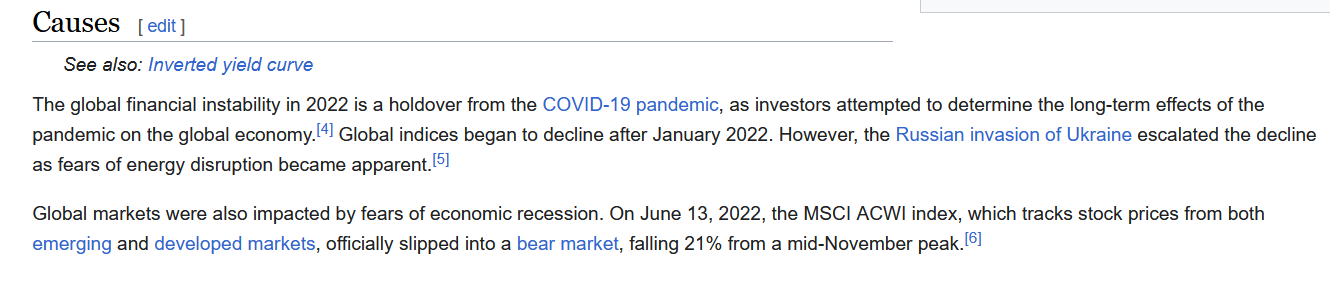
<br>
Due to the above, it was quite expected that the stocks we select would decline in this period.
* We noticed that among a set of stocks, we can determine with some confidence on which stocks would perform best for momentum trading by plotting the growth of each stock. (We were able to correctly guess 6 out of 9 top performing stocks in momentum trading)
* Choosing the risk limits for a stock optimization requires fine-tuning, as the risk levels would depend on the stocks. It is hard to choose a portfolio when the risk levels are too high, too low or not numerous enough
* It is important to convert the stock price data to percentage change in stock value before performing optimization. Otherwise, the covariance matrix would produce high values which would only generate high and inaccurate risk values. This will fail the risk constraint and lead to only infeasible solutions.
* We hoped that our portfolio would outperform the S&P 500 portfolio when comparing the buy-and-hold strategies but it is apparent that S&P 500 is much more stable and has a lesser risk than our portfolio
* Our portfolio performed well when momentum trading strategy was applied to the constituent stocks (see above plot) but even it was finally overtaken by Buy and hold and momentum trading of S&P 500. This shows that the momentum trading of our portfolio has potential to perform really well when there is a steady growth in the constituent stock values.


# Team contribution

* Kanchan Sharma - Performed data cleaning and implemented Momentum trading for the 30 stocks
* Srihari Madhavan - Performed Portfolio Optimization, code optimization and error resolution. Additionally added insights and inferences of the outputs
* Pavani Pratyusha - Coded Analysis section for momentum trading and buy-and-hold of S&P500 stock.
* Vaishnavi Tiwari - Coded the Analysis section for momentum trading and buy-and-hold strategy on the optimized portfolio.